In [1]:
import torch
from torch.optim import Adam, SGD

import numpy as np

from data.data import *
from unet_model import *
from metrics import *

from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


### Data Path

In [3]:
DATASET_PATH = "./data/repo/FloodNetData"

# TRAIN_REGION = "Region_2_3_TRAIN_Region_1_TEST"
# TEST_REGION= "Region_1_TEST"

TRAIN_REGION = "Region_1_3_TRAIN_Region_2_TEST"
TEST_REGION= "Region_2_TEST"

# TRAIN_REGION = "Region_1_2_TRAIN_Region_3_TEST"
# TEST_REGION= "Region_3_TEST"


cropped_train_data_path = f"./data/{TRAIN_REGION}/cropped_data_train"

cropped_val_test_data_path = f"./data/{TRAIN_REGION}/cropped_data_val_test"

## Get Meta-Data of Dataset

In [4]:
def get_meta_data(DATASET_PATH):
    
    DATASET = os.listdir(DATASET_PATH)
    DATASET = [file for file in DATASET if  file.endswith(".npy") and re.search("Features", file)]

    META_DATA = dict()

    for file_name in DATASET:
        file = np.load(os.path.join(DATASET_PATH, file_name))
        #print(file.shape)
        file_height, file_width, _ = file.shape
        #print(file_height)
        #print(file_width)

        elev_data = file[:, :, 3]
        file_elev_max = np.max(elev_data)
        file_elev_min = np.min(elev_data)
        # print(file_elev_max)
        # print(file_elev_min)

        if file_elev_max>config.GLOBAL_MAX:
            config.GLOBAL_MAX = file_elev_max
        if file_elev_min<config.GLOBAL_MIN:
            config.GLOBAL_MIN = file_elev_min


        META_DATA[file_name] = {"height": file_height,
                                "width": file_width}
        
    return META_DATA

In [5]:
META_DATA = get_meta_data(DATASET_PATH)
print(META_DATA)
print(config.GLOBAL_MAX)
print(config.GLOBAL_MIN)

{'Region_1_Features7Channel.npy': {'height': 1856, 'width': 4104}, 'Region_2_Features7Channel.npy': {'height': 1792, 'width': 4032}, 'Region_3_Features7Channel.npy': {'height': 2240, 'width': 4704}}
76.049
-4.965000152587891


### Torch Dataset

In [6]:
elev_train_dataset = get_dataset(cropped_train_data_path)
elev_val_test_dataset = get_dataset(cropped_val_test_data_path)

In [7]:
train_seq = np.arange(0, len(elev_train_dataset), dtype=int)
# train_seq = np.arange(0, 8, dtype=int)
print(len(train_seq))

d_len = len(elev_val_test_dataset)
print(d_len)

val_idx = int(0.5*d_len)
val_seq = np.arange(0, val_idx, 1, dtype=int)
print(len(val_seq))

test_seq = np.arange(0, d_len, 1, dtype=int)
# test_seq = np.arange(0, d_len, 1, dtype=int)
print(len(test_seq))


half_test_seq = np.arange(len(val_seq), d_len, 1, dtype=int)
print(len(half_test_seq))

1161
448
224
448
224


In [8]:
BATCH_SIZE = 4

In [9]:
train_dataset = torch.utils.data.Subset(elev_train_dataset, train_seq)
val_dataset = torch.utils.data.Subset(elev_val_test_dataset, val_seq)
test_dataset = torch.utils.data.Subset(elev_val_test_dataset, test_seq)

In [10]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

## U-net

In [11]:
IN_CHANNEL = 4
N_CLASSES = 3
EPOCHS = 100
VAL_FREQUENCY = 10
SAVE_FREQUENCY = None

In [12]:
model = UNet(IN_CHANNEL, N_CLASSES, ultrasmall = True).to(DEVICE)
# print(model)

##optimizer = Adam(model.parameters(), lr = 1e-6)
optimizer = SGD(model.parameters(), lr = 1e-7)

criterion = torch.nn.CrossEntropyLoss(reduction = 'sum', ignore_index = 0)

# Evaluator

In [13]:
elev_eval = Evaluator()

# Training Loop

In [14]:
model_path = f"./saved_models/{TEST_REGION}/saved_model_{250}.ckpt"

if os.path.exists(model_path):
    checkpoint = torch.load(model_path)
    resume_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model'])
else:
    resume_epoch = 0
    
print(resume_epoch)

0


In [15]:
train_loss_dict = dict()
val_loss_dict = dict()
min_val_loss = 1e10

for epoch in range(resume_epoch, EPOCHS):
    
    ## Model gets set to training mode
    model.train()
    train_loss = 0
    
    for data_dict in tqdm(train_loader):
        
        ## Retrieve data from data dict and send to deivce
        
        ## RGB data
        rgb_data = data_dict['rgb_data'].float().to(DEVICE)
        rgb_data.requires_grad = True
        
        labels = data_dict['labels'].long().to(DEVICE)
        labels.requires_grad = False  
        
        ## Get model prediction
        pred = model(rgb_data)
        
        ## Backprop Loss
        optimizer.zero_grad() 
        loss = criterion.forward(pred, labels)
        ##print("Loss: ", loss.item())
        
        loss.backward()
        optimizer.step()
        
        ## Record loss for batch
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_loss_dict[epoch+1] = train_loss
    print(f"Epoch: {epoch+1} Training Loss: {train_loss}" )
    
    
    #=====================================================================================
    
    
    ## Do model validation for epochs that match VAL_FREQUENCY
    if (epoch+1)%VAL_FREQUENCY == 0:    
        
        ## Model gets set to evaluation mode
        model.eval()
        val_loss = 0 
                
        print("Starting Validation")
        
        for data_dict in tqdm(val_loader):
            
            ## RGB data
            rgb_data = data_dict['rgb_data'].float().to(DEVICE)

            ## Data labels
            labels = data_dict['labels'].long().to(DEVICE)
            
            ## Get model prediction
            pred = model(rgb_data)            
            
            ## Backprop Loss
            loss = criterion.forward(pred, labels)
            ##print("Loss: ", loss.item())

            ## Record loss for batch
            val_loss += loss.item()
            
            ## Remove pred and GT from GPU and convert to np array
            pred_labels_np = pred.detach().cpu().numpy() 
            gt_labels_np = labels.detach().cpu().numpy()
        
        val_loss /= len(val_loader)
        val_loss_dict[epoch+1] = val_loss
        print(f"Epoch: {epoch+1} Validation Loss: {val_loss}" )
        
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            print("Saving Model")
            torch.save({'epoch': epoch + 1,  # when resuming, we will start at the next epoch
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()}, 
                        f"./saved_models/{TEST_REGION}/saved_model_{epoch+1}.ckpt")
         

    
    
        ### Save model Periodically, every multiple of 2
        if SAVE_FREQUENCY and ((epoch+1)%SAVE_FREQUENCY == 0):
            torch.save({'epoch': epoch + 1,  # when resuming, we will start at the next epoch
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()
                        }, 
                        f"./saved_model_{epoch+1}.ckpt")

100%|██████████| 291/291 [00:55<00:00,  5.29it/s]


Epoch: 1 Training Loss: 43327.897524699314


100%|██████████| 291/291 [00:43<00:00,  6.76it/s]


Epoch: 2 Training Loss: 40093.704608301116


 21%|██▏       | 62/291 [00:08<00:31,  7.36it/s]


KeyboardInterrupt: 

### Plot Training and Validation Curve

In [16]:
def plot_curve(train_loss_dict, val_loss_dict):
    plt.figure(figsize = (8, 8))

    val_epochs = list(val_loss_dict.keys())
    val_losses = list(val_loss_dict.values())
    val_len = len(val_epochs)

    train_epochs = list(train_loss_dict.keys())
    train_losses = list(train_loss_dict.values())
    # train_losses = train_losses[:val_len]

    print(len(val_epochs))
    print(len(train_losses))

    plt.plot(val_epochs, val_losses, "bs-.", label = "Val Loss")
    plt.plot(train_epochs, train_losses, "rp-.", label = "Train Loss")

    plt.xlabel("EPOCH")  
    plt.ylabel("LOSS")
    plt.title("Training & Validation Curve")
    plt.legend(loc = 'upper right', prop={'size' : 15})
    # plt.savefig(f'{metric}.pdf', format = 'pdf')

    plt.show()

54
54


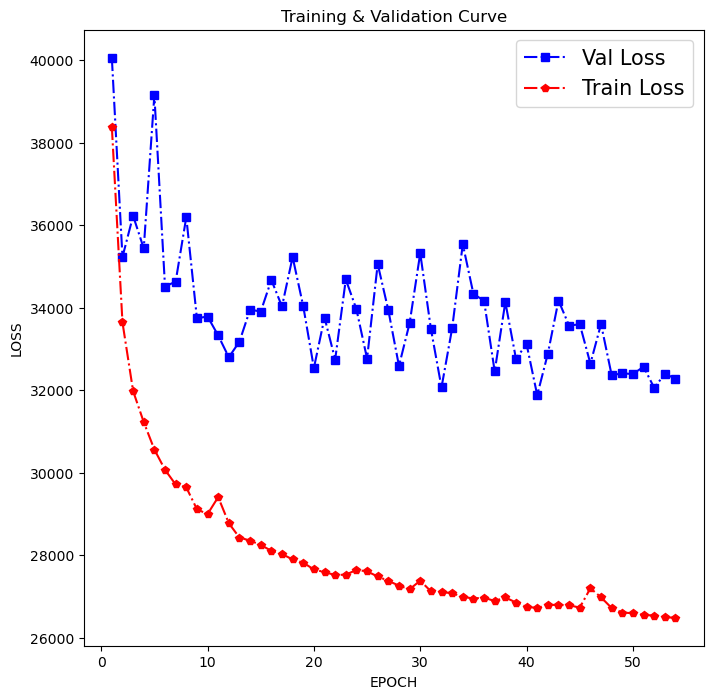

In [17]:
# lr = 1e-7, "Region_1_2_TRAIN_Region_2_TEST"
plot_curve(train_loss_dict, val_loss_dict)

# Predict & Evaluate

In [16]:
model_path = f"./saved_models/{TEST_REGION}/saved_model_{10}.ckpt"

if os.path.exists(model_path):
    checkpoint = torch.load(model_path)
    resume_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model'])
else:
    resume_epoch = 0

print(resume_epoch)

10


In [17]:
def run_pred(data_loader):
    
    ## Model gets set to evaluation mode
    model.eval()
    pred_patches_dict = dict()

    for data_dict in tqdm(data_loader):
        
        ## RGB data
        rgb_data = data_dict['rgb_data'].float().to(DEVICE)

        ## Data labels
        labels = data_dict['labels'].long().to(DEVICE)

        ## Get filename
        filename = data_dict['filename']
        # print("filename: ", filename)

        ## Get model prediction
        pred = model(rgb_data)


        ## Remove pred and GT from GPU and convert to np array
        pred_labels_np = pred.detach().cpu().numpy() 
        gt_labels_np = labels.detach().cpu().numpy()
        
        ## Save Image and RGB patch
        for idx in range(rgb_data.shape[0]):
            pred_patches_dict[filename[idx]] = pred_labels_np[idx, :, :, :]
        
    return pred_patches_dict

In [18]:
def find_patch_meta(pred_patches_dict):
    y_max = 0
    x_max = 0

    for item in pred_patches_dict:

        ##print(item)

        temp = int(item.split("_")[3])
        if temp>y_max:
            y_max = temp

        temp = int(item.split("_")[5])
        if temp>x_max:
            x_max = temp


    y_max+=1
    x_max+=1
    print(f"y_max: {y_max}, x_max: {x_max}")
    print(f"Number of patches: {y_max*x_max}")

    print(f"rgb_pred_patches len: {len(pred_patches_dict)}")
    
    return y_max, x_max

In [19]:
def stitch_patches(pred_patches_dict):
    y_max, x_max = find_patch_meta(pred_patches_dict)
    
    for i in range(y_max):
        for j in range(x_max):
            dict_key = f"{TEST_REGION[:-5]}_y_{i}_x_{j}_features.npy"
            #print(dict_key)
        
            pred_patch = pred_patches_dict[dict_key]
            pred_patch = np.transpose(pred_patch, (1, 2, 0))

            rgb_patch = np.load(os.path.join(cropped_val_test_data_path, dict_key))[:, :, :3]


            if j == 0:
                rgb_x_patches = rgb_patch
                pred_x_patches = pred_patch
            else:
                rgb_x_patches = np.concatenate((rgb_x_patches, rgb_patch), axis = 1)
                pred_x_patches = np.concatenate((pred_x_patches, pred_patch), axis = 1)

            ## rgb_patches.append(rgb_patch)
            ## pred_patches.append(pred_patch)
    
        if i == 0:
            rgb_y_patches = rgb_x_patches
            pred_y_patches = pred_x_patches
        else:
            rgb_y_patches = np.vstack((rgb_y_patches, rgb_x_patches))
            pred_y_patches = np.vstack((pred_y_patches, pred_x_patches))
        

    rgb_stitched = rgb_y_patches.astype('uint8')
    pred_stitched = np.argmax(pred_y_patches, axis = -1)
    
    return rgb_stitched, pred_stitched

In [20]:
def center_crop(stictched_data, image = False):
    dict_key = f"{TEST_REGION[:-5]}_Features7Channel.npy"
    
    if image:
        current_height, current_width, _ = stictched_data.shape
    else:
        current_height, current_width = stictched_data.shape    
    print("current_height: ", current_height)
    print("current_width: ", current_width)
    
    original_height = META_DATA[dict_key]['height']
    original_width = META_DATA[dict_key]['width']
    print("original_height: ", original_height)
    print("original_width: ", original_width)
    
    height_diff = current_height-original_height
    width_diff = current_width-original_width
    
    print("height_diff: ", height_diff)
    print("width_diff: ", width_diff)
    
    
    cropped = stictched_data[height_diff//2:current_height-height_diff//2, width_diff//2: current_width-width_diff//2]
    
    return cropped

### Run Prediction

In [21]:
pred_patches_dict = run_pred(test_loader)

100%|██████████| 112/112 [00:13<00:00,  8.03it/s]


### Stitch Patches

In [22]:
rgb_stitched, pred_stitched = stitch_patches(pred_patches_dict)

y_max: 14, x_max: 32
Number of patches: 448
rgb_pred_patches len: 448


### Remove Padding

In [23]:
rgb_unpadded = center_crop(rgb_stitched, image = True)
print(rgb_unpadded.shape)

current_height:  1792
current_width:  4096
original_height:  1792
original_width:  4032
height_diff:  0
width_diff:  64
(1792, 4032, 3)


In [24]:
pred_unpadded = center_crop(pred_stitched)
pred_unpadded = np.where(pred_unpadded == 2, 0, pred_unpadded)

current_height:  1792
current_width:  4096
original_height:  1792
original_width:  4032
height_diff:  0
width_diff:  64


## Vizualize Pred

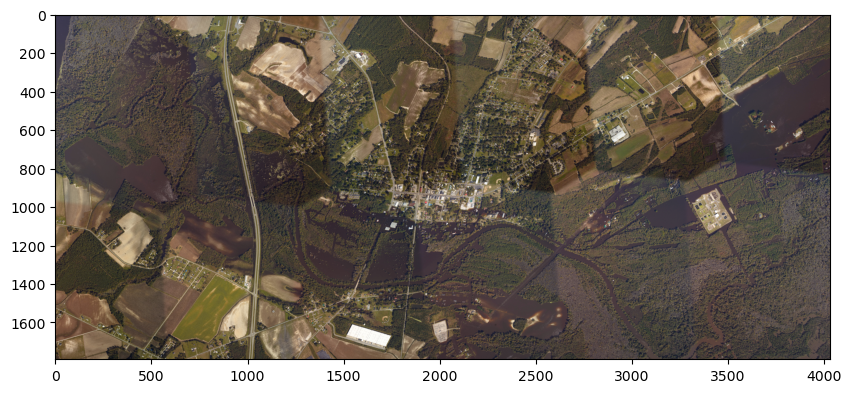

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(rgb_unpadded.astype('int'))

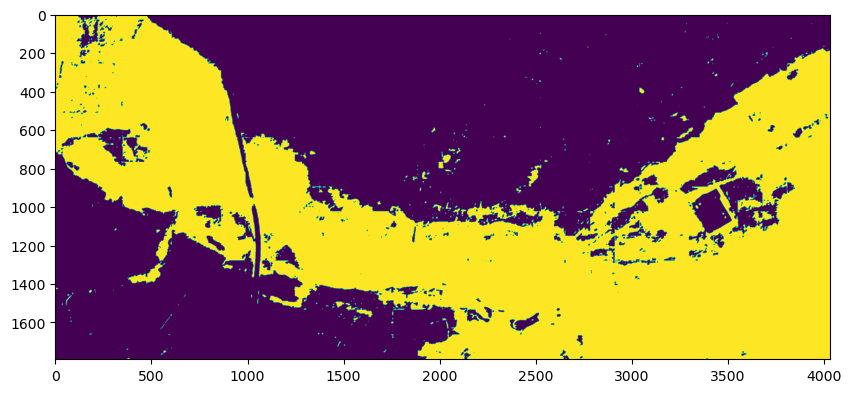

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(pred_unpadded.astype('int'))

(1792, 4032)


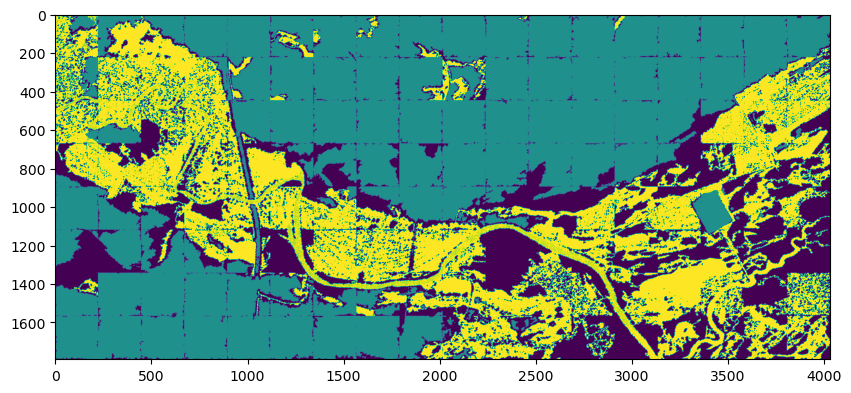

In [27]:
gt_labels = np.load(f"./data/repo/FloodNetData/{TEST_REGION[:-5]}_labels.npy")

print(gt_labels.shape)
# print(gt_labels)
plt.figure(figsize=(10,10))
plt.imshow(gt_labels.astype('int'))

### Overlay

In [28]:
flood = np.where(pred_unpadded == 1, 1, 0)
flood = np.expand_dims(flood, axis = -1)
flood = flood*np.array([ [ [255, 0, 0] ] ])
print(flood.shape)

combined = (flood).astype('uint8')
print(combined.shape)

(1792, 4032, 3)
(1792, 4032, 3)


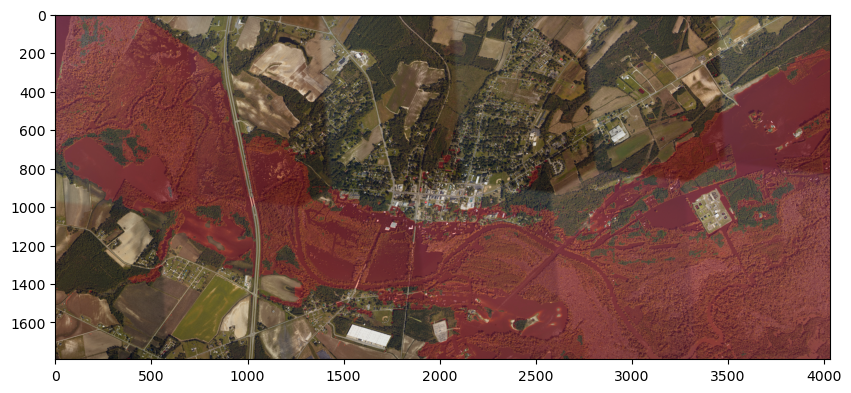

In [29]:
blended = cv2.addWeighted(rgb_unpadded, 0.9, combined, 0.22, 0).astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(blended)

In [30]:
cv2.imwrite(f"./output/{TEST_REGION[:-5]}_overlay.jpg", cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))

True

## Evaluate

In [31]:
elev_eval.run_eval(pred_unpadded, gt_labels)

Dry Accuracy:  95.72506405413019
Dry Precision:  95.73251358066283
Dry Recall:  97.23530321111036
Dry F-score:  96.47805670333254


Flood Accuracy:  95.72506405413019
Flood Precision:  95.71333223119981
Flood Recall:  93.439075044429
Flood F-score:  94.56253147306091
